In [1]:
import os
import pandas as pd
import numpy as np
import fcsparser

# ==== 配置路径 ====
BASE_DIR = r"F:\Desktop\AML"  # 你的 AML 数据集路径
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

# ==== 读取 train 和 test 标签表 ====
train_labels = pd.read_csv(os.path.join(TRAIN_DIR, "train_labels.csv"))
train_labels["split"] = "train"

test_labels = pd.read_csv(os.path.join(TEST_DIR, "test_labels.csv"))
test_labels["split"] = "test"

# 合并
labels_df = pd.concat([train_labels, test_labels], ignore_index=True)

# ==== 读取单个 FCS 文件 ====
def read_fcs_file(fcs_path):
    meta, data = fcsparser.parse(fcs_path, reformat_meta=True)
    return meta, data

# ==== arcsinh 变换 ====
def arcsinh_transform(df, cofactor=5):
    return np.arcsinh(df / cofactor)

# ==== 处理所有样本 ====
all_samples = []
for idx, row in labels_df.iterrows():
    folder = TRAIN_DIR if row["split"] == "train" else TEST_DIR
    fcs_path = os.path.join(folder, row["fcs_file"])

    if not os.path.exists(fcs_path):
        print(f"!文件不存在: {fcs_path}")
        continue

    meta, cell_df = read_fcs_file(fcs_path)

    numeric_cols = cell_df.select_dtypes(include=[np.number]).columns
    cell_df[numeric_cols] = arcsinh_transform(cell_df[numeric_cols])

    feature_vector = cell_df[numeric_cols].agg(['mean', 'std']).T
    feature_vector = feature_vector.stack().to_frame().T
    feature_vector.columns = [
        f"{col}_{stat}" 
        for col in numeric_cols 
        for stat in ['mean', 'std']
    ]

    feature_vector['label'] = row['label']
    feature_vector['fcs_file'] = row['fcs_file']
    feature_vector['split'] = row['split']

    all_samples.append(feature_vector)

# ==== 合并成 DataFrame ====
features_df = pd.concat(all_samples, ignore_index=True)

print("数据形状:", features_df.shape)
print(features_df.head())

# 保存
features_df.to_csv(os.path.join(BASE_DIR, "AML_features.csv"), index=False)
print("✅ 已保存 AML_features.csv")


数据形状: (359, 83)
   IgG1-FITC_mean  IgG1-FITC_std  IgG1-PE_mean  IgG1-PE_std  CD45-ECD-1_mean  \
0        4.205569       0.744767      4.027208     0.893186         5.165892   
1        3.529439       1.761160      3.081222     1.774232         5.245674   
2        3.223123       1.566584      2.711990     1.876633         5.159954   
3        4.382265       0.676211      3.858559     1.202075         5.310210   
4        4.217891       0.735151      3.693399     1.230356         5.012330   

   CD45-ECD-1_std  IgG1-PC5_mean  IgG1-PC5_std  IgG1-PC7_mean  IgG1-PC7_std  \
0        0.241482       2.846835      1.717303       2.547615      1.558755   
1        0.456727       2.401160      1.953040       1.824019      1.703231   
2        0.759650       1.749093      1.849265       2.534286      1.685740   
3        0.314191       3.198882      1.731894       1.695242      1.637843   
4        0.475683       2.792344      1.793038       2.439587      1.603638   

   ...  FL2-Log_std  7AAD_me

Loaded features shape: (359, 83)
Train samples: 286, Test samples: 73

Training LogisticRegression ...

Training RandomForest ...

Training SVM ...

Training KNN ...

Training XGBoost ...


F:\python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:26:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


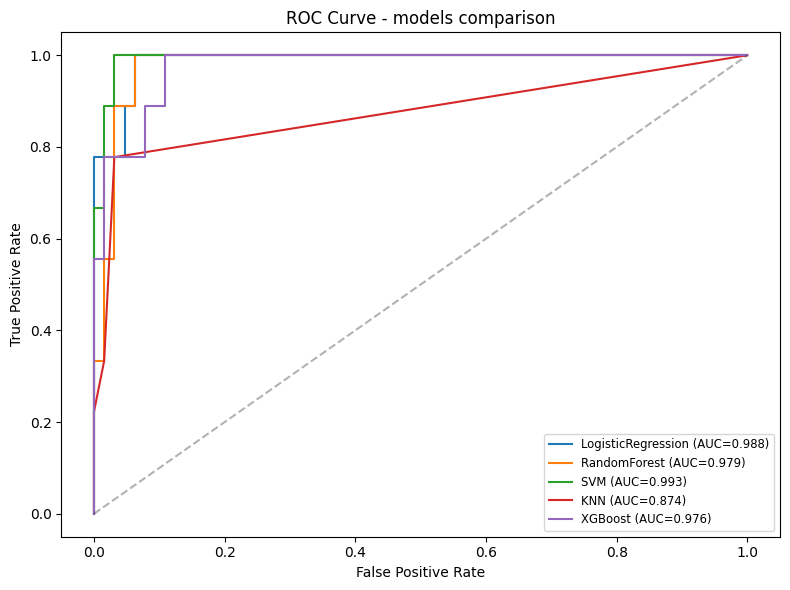


Model performance (sorted by AUC):
                model  accuracy  precision    recall        f1       auc
2                 SVM  0.945205        1.0  0.555556  0.714286  0.993056
0  LogisticRegression  0.958904        1.0  0.666667  0.800000  0.987847
1        RandomForest  0.917808        0.8  0.444444  0.571429  0.979167
4             XGBoost  0.945205        1.0  0.555556  0.714286  0.975694
3                 KNN  0.904110        1.0  0.222222  0.363636  0.874132

Saved performance table to F:\Desktop\AML\results\figures\model_performance.csv

Running UMAP for 2D visualization ...


F:\python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


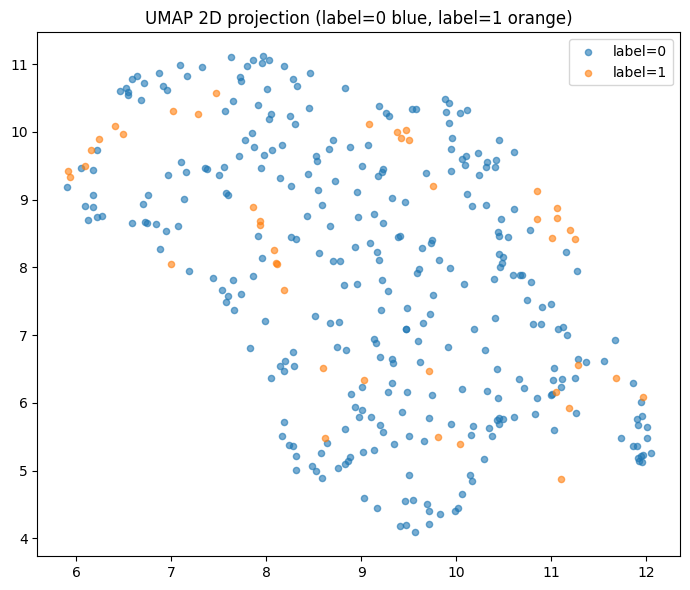


All done. Figures and model table saved in: F:\Desktop\AML\results\figures


In [3]:
# -*- coding: utf-8 -*-
"""
Multi-model comparison + ROC + Confusion Matrix + UMAP visualization
Requires: pandas, numpy, scikit-learn, matplotlib, umap-learn (optional), xgboost (optional)
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.model_selection import GridSearchCV

# optional imports
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False

try:
    import umap
    has_umap = True
except Exception:
    has_umap = False

# === config ===
BASE_DIR = r"F:\Desktop\AML"   
FEATURES_FILE = os.path.join(BASE_DIR, "AML_features.csv")
OUT_DIR = os.path.join(BASE_DIR, "results", "figures")
os.makedirs(OUT_DIR, exist_ok=True)
RND = 42

# === load features ===
df = pd.read_csv(FEATURES_FILE)
print("Loaded features shape:", df.shape)
# Drop non-feature columns
meta_cols = ['label', 'fcs_file', 'split']
for c in meta_cols:
    if c not in df.columns:
        raise ValueError(f"Expected column '{c}' in {FEATURES_FILE}")

X = df.drop(columns=meta_cols)
y = df['label'].astype(int)
splits = df['split'].values

# train/test selection using provided split
train_idx = (splits == 'train')
test_idx = (splits == 'test')
X_train, X_test = X.loc[train_idx].copy(), X.loc[test_idx].copy()
y_train, y_test = y.loc[train_idx].copy(), y.loc[test_idx].copy()

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# standardize features (fit on train only)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# === define models ===
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RND),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RND),
    "SVM": SVC(kernel='rbf', probability=True, random_state=RND),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

if has_xgb:
    models["XGBoost"] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND)
else:
    # fallback to GradientBoostingClassifier if xgboost not installed
    models["GradBoost"] = GradientBoostingClassifier(random_state=RND)

# === train, predict, evaluate ===
results = []
plt.figure(figsize=(8,6))
for name, clf in models.items():
    print(f"\nTraining {name} ...")
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)
    y_prob = clf.predict_proba(X_test_s)[:,1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test_s)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_prob)
    except Exception:
        auc = np.nan

    results.append({
        "model": name, "accuracy": acc, "precision": prec,
        "recall": rec, "f1": f1, "auc": auc
    })

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

    # confusion matrix plot (save each)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig_cm, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(f"Confusion Matrix - {name}")
    fig_cm.tight_layout()
    fig_cm.savefig(os.path.join(OUT_DIR, f"confusion_{name}.png"), dpi=200)
    plt.close(fig_cm)

# finalize ROC plot
plt.plot([0,1],[0,1],'k--', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - models comparison")
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "roc_comparison.png"), dpi=200)
plt.show()

# results table
res_df = pd.DataFrame(results).sort_values(by='auc', ascending=False)
print("\nModel performance (sorted by AUC):")
print(res_df)

res_df.to_csv(os.path.join(OUT_DIR, "model_performance.csv"), index=False)
print(f"\nSaved performance table to {os.path.join(OUT_DIR, 'model_performance.csv')}")

# === UMAP visualization ===
if not has_umap:
    print("\nNOTICE: 'umap' package not installed. Install with: pip install umap-learn")
else:
    print("\nRunning UMAP for 2D visualization ...")
    reducer = umap.UMAP(n_components=2, random_state=RND)
    X_all_s = scaler.transform(X)  # use scaler fitted on train
    emb = reducer.fit_transform(X_all_s)

    plt.figure(figsize=(7,6))
    colors = ['tab:blue','tab:orange']
    for lab in [0,1]:
        mask = (y.values == lab)
        plt.scatter(emb[mask,0], emb[mask,1], s=20, alpha=0.6, label=f"label={lab}")
    plt.legend()
    plt.title("UMAP 2D projection (label=0 blue, label=1 orange)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "umap_labels.png"), dpi=200)
    plt.show()

print("\nAll done. Figures and model table saved in:", OUT_DIR)


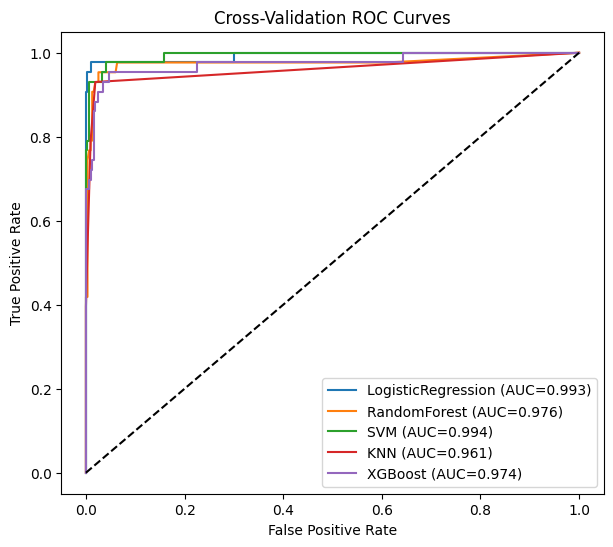


Cross-Validation Results:
                 model       auc  avg_precision
2                 SVM  0.993671       0.969697
0  LogisticRegression  0.992641       0.981319
1        RandomForest  0.976045       0.938236
4             XGBoost  0.974389       0.927180
3                 KNN  0.960627       0.893833


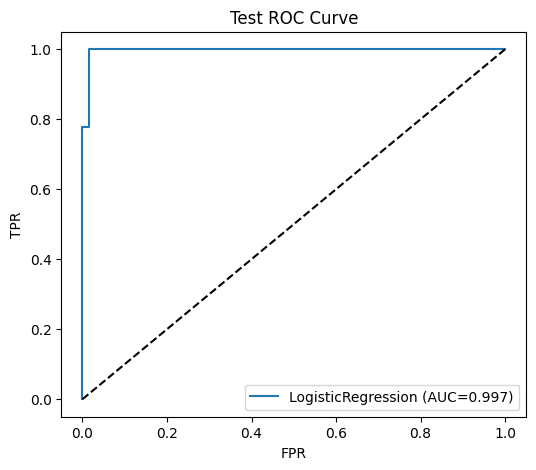

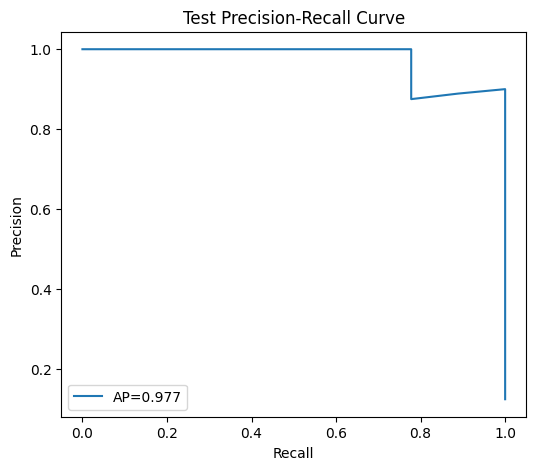

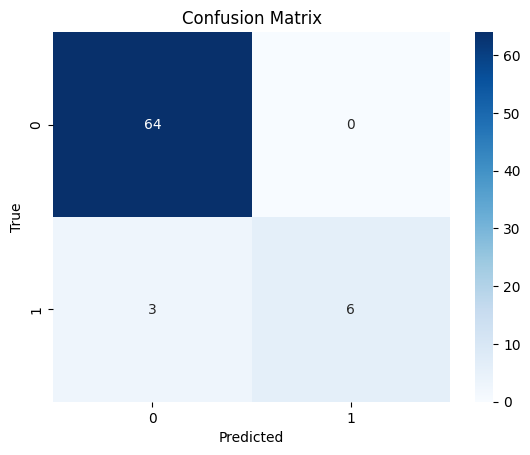


Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        64
           1       1.00      0.67      0.80         9

    accuracy                           0.96        73
   macro avg       0.98      0.83      0.89        73
weighted avg       0.96      0.96      0.96        73



F:\python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


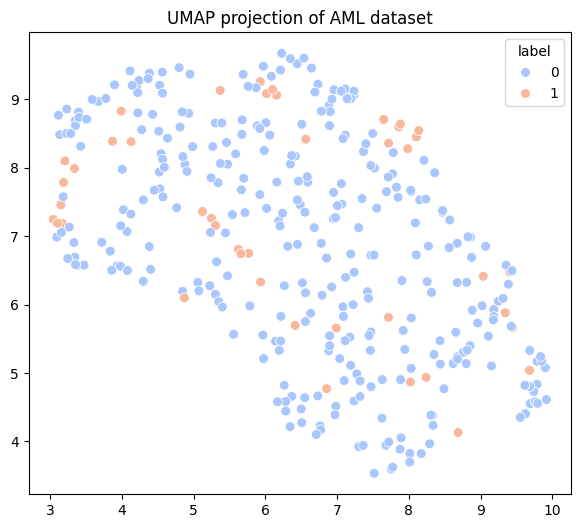

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import umap.umap_ as umap

# 1. 读取数据
df = pd.read_csv("F:\Desktop\AML\AML_features.csv")
X = df.drop(columns=["label", "fcs_file", "split"])
y = df["label"]

# 2. 模型字典
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss")
}

# 3. 交叉验证评估
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

plt.figure(figsize=(7, 6))
for name, model in models.items():
    y_proba = cross_val_predict(model, X, y, cv=skf, method="predict_proba")[:, 1]
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y, y_proba)
    ap = average_precision_score(y, y_proba)

    cv_results.append({"model": name, "auc": roc_auc, "avg_precision": ap})
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Cross-Validation ROC Curves")
plt.legend()
plt.show()

cv_df = pd.DataFrame(cv_results).sort_values("auc", ascending=False)
print("\nCross-Validation Results:\n", cv_df)

# 4. 固定 test split
X_train = df[df["split"] == "train"].drop(columns=["label", "fcs_file", "split"])
y_train = df[df["split"] == "train"]["label"]
X_test = df[df["split"] == "test"].drop(columns=["label", "fcs_file", "split"])
y_test = df[df["split"] == "test"]["label"]

final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

# ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LogisticRegression (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

# PR 曲线
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Precision-Recall Curve")
plt.legend()
plt.show()

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 5. UMAP 可视化
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(StandardScaler().fit_transform(X))
plt.figure(figsize=(7,6))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=y, palette="coolwarm", s=50)
plt.title("UMAP projection of AML dataset")
plt.show()
